### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [21]:
import torch
import copy
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import Block, Encoder, Decoder, UNet
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F
import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [8]:
# pip install tqdm

In [9]:
# del sys.modules['data_func']
import sys
# del sys.modules['model']


In [10]:
# pip install torchvision

### Data Preparation & Augmentation

In [11]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [12]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        # ToTensorV2()
    ])

train_set = ImageDataset('./train/', './train_mask', train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)

In [13]:
val_set = ImageDataset('./val/', './val_mask', None)
valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True)
test_set = ImageDataset('./test/', './test_mask', None)
testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True)

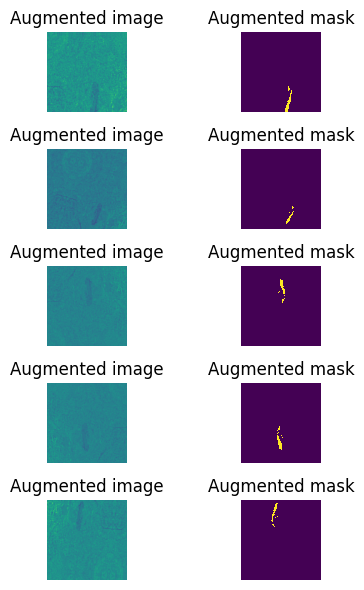

In [14]:
visualize_augmentations(train_set, idx=1, samples=5)

#### Train & Evaluate

In [23]:
lr = 3e-4
epochs = 20
unet = UNet().to(device)
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=lr)

trainSteps = len(train_set) // train_batch_size
testSteps = len(val_set) // val_batch_size

H = {"train_loss": [], "test_loss": []}
print(f"[INFO] found {len(train_set)} examples in the training set...")
print(f"[INFO] found {len(val_set)} examples in the test set...")

[INFO] found 16 examples in the training set...
[INFO] found 4 examples in the test set...


In [ ]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(epochs)):
    unet.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    for (i, (x, y)) in enumerate(trainloader):
        (x, y) = (x.to(device), y.to(device))
        pred = unet(x)
        loss = lossFunc(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in valloader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
torch.save(unet, './models/unet.pth')


# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)


[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]